In [58]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
import pandas as pd
from tensorflow import keras
import os

## 读取数据并转换

In [59]:
# 读取csv文件成为pandas的DataFrame
train_file = './data/titanic/train.csv'
eval_file = './data/titanic/eval.csv'

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

print(train_df.head())  # head函数去除前几条数据，默认前5条
print(eval_df.head())

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
   survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4         

In [60]:
y_train = train_df.pop('survived')  # pop函数可以把相应的字段从数据集里去除，并返回该字段的值
y_eval = eval_df.pop('survived')

train_df.describe()  #显示统计信息

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


## 显示统计信息

In [61]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


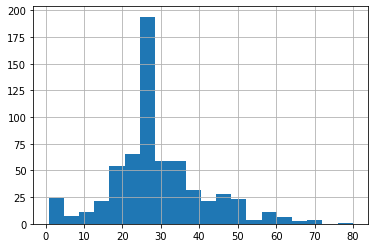

In [62]:
train_df.age.hist(bins=20)   # 查看所有人的年龄分布：hist函数可以绘制直方图，bins参数表示柱子的条数

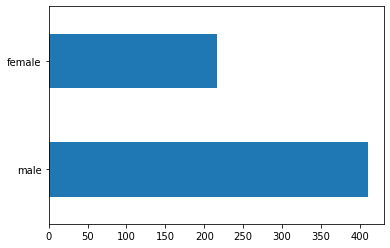

In [63]:
train_df.sex.value_counts().plot(kind='barh') # 显示男女数量,kind='barh'表示横向柱状图，纵向是barv

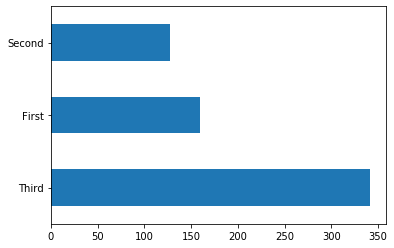

In [64]:
train_df['class'].value_counts().plot(kind='barh')   # 显示仓位人数

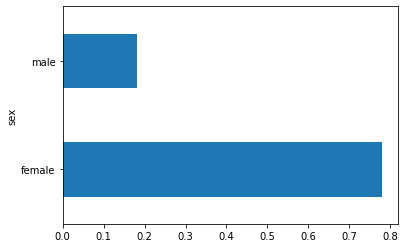

In [65]:
# 显示男性有多少人获救，女性有多少人获救
pd.concat([train_df, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh') # 合并后根据性别分组，然后求是否获救的均值

## 模型搭建

### 数据处理

In [66]:
# 使用feature columns对数据做封装
# 将数据分为离散特征和连续特征
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']   # 离散特征
numeric_columns = ['age', 'fare']   # 连续特征
feature_columns = []
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()   # unique函数获取一个属性所有可能的值
    print(categorical_column, vocab)
    feature_column = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(categorical_column, vocab))
    feature_columns.append(feature_column)

for numeric_column in numeric_columns:
    feature_columns.append(tf.feature_column.numeric_column(numeric_column, dtype=tf.float32))

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [67]:
# 构建dataset
def make_dataset(data_df, label_df, epochs=10, shuffle=True, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

train_dataset = make_dataset(train_df, y_train, batch_size=5)

In [68]:
# 数据展示
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: id=32029, shape=(5,), dtype=string, numpy=array([b'female', b'male', b'female', b'female', b'male'], dtype=object)>, 'age': <tf.Tensor: id=32021, shape=(5,), dtype=float64, numpy=array([28., 39., 24., 24., 23.])>, 'n_siblings_spouses': <tf.Tensor: id=32027, shape=(5,), dtype=int32, numpy=array([1, 1, 0, 0, 0], dtype=int32)>, 'parch': <tf.Tensor: id=32028, shape=(5,), dtype=int32, numpy=array([0, 5, 0, 0, 0], dtype=int32)>, 'fare': <tf.Tensor: id=32026, shape=(5,), dtype=float64, numpy=array([51.8625, 31.275 , 13.    , 83.1583, 10.5   ])>, 'class': <tf.Tensor: id=32023, shape=(5,), dtype=string, numpy=array([b'First', b'Third', b'Second', b'First', b'Second'], dtype=object)>, 'deck': <tf.Tensor: id=32024, shape=(5,), dtype=string, numpy=array([b'D', b'unknown', b'unknown', b'C', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: id=32025, shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Southampton', b'Cherbourg',
       b'Southampton'],

In [69]:
# keras.layers.DenseFeature 将feature_columns应用到dataset
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[ 29.       0.       1.       0.       1.       0.       0.       0.
    0.       0.       1.       0.       0.       0.       1.       0.
    0.       0.     211.3375   0.       1.       0.       0.       0.
    0.       0.       1.       0.       0.       0.       0.       0.
    0.       1.    ]
 [ 28.       0.       1.       1.       0.       0.       1.       0.
    0.       0.       0.       0.       0.       0.       1.       0.
    0.       0.       8.05     0.       1.       0.       0.       

### 构建keras模型

In [70]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [71]:
# 训练模型
# 1.model.fit
# 2.model -> estimator -> train

# 1.使用model.fit进行训练
train_dataset = make_dataset(train_df, y_train, epochs=100)
eval_dataset = make_dataset(eval_df, y_eval, epochs=1, shuffle=False)
history = model.fit(train_dataset, validation_data=eval_dataset, steps_per_epoch=18, validation_steps=8, epochs=100)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train for 18 steps, validate for 8 steps
Epoch 1/100
18/18 [==============================] - 3s 140ms/step - loss: 0.7203 - accuracy: 0.6319 - val_loss: 0.7522 - val_accuracy: 0.6133
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.7009 - accuracy: 0.6562 - val_loss: 0.6744 - val_accuracy: 0.6797
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 0.6795 - accuracy: 0.6858 - val_loss: 0.5867 - val_accuracy: 0.6758
Epoch 4/100
18/18 [=======================

18/18 [==============================] - 0s 8ms/step - loss: 0.3974 - accuracy: 0.8177 - val_loss: 0.4936 - val_accuracy: 0.8047
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3435 - accuracy: 0.8663 - val_loss: 0.4932 - val_accuracy: 0.7852
Epoch 55/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3658 - accuracy: 0.8490 - val_loss: 0.5129 - val_accuracy: 0.7695
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3776 - accuracy: 0.8542 - val_loss: 0.4806 - val_accuracy: 0.7930
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3842 - accuracy: 0.8299 - val_loss: 0.4948 - val_accuracy: 0.7969
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3488 - accuracy: 0.8628 - val_loss: 0.4845 - val_accuracy: 0.7930
Epoch 59/100
18/18 [==============================] - 0s 8ms/step - loss: 0.3545 - accuracy: 0.8507 - val_loss: 0.4820 - val_accuracy: 0.7891
Epoch 60/100
18/18 

In [76]:
# 2.model -> estimator -> train
estimator = keras.estimator.model_to_estimator(model)
def get_data_set():
    return make_dataset(train_df, y_train, epochs=100)
# 参数input_fn接受一个函数，且该函数只能返回(features, labels)或dataset:(feature, label)
# estimator.train(input_fn = lambda : make_dataset(train_df, y_train, epochs=100))
estimator.train(input_fn=get_data_set)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/b6/wpgkbcmn2hxcbg2_j5904vfm0000gn/T/tmp0b4a2bqv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x156513b90>, '_task_type': 'worker', '_task_id': 0, '_glo

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.

In [77]:
ddd = get_data_set()
ddd

<BatchDataset shapes: ({sex: (None,), age: (None,), n_siblings_spouses: (None,), parch: (None,), fare: (None,), class: (None,), deck: (None,), embark_town: (None,), alone: (None,)}, (None,)), types: ({sex: tf.string, age: tf.float64, n_siblings_spouses: tf.int32, parch: tf.int32, fare: tf.float64, class: tf.string, deck: tf.string, embark_town: tf.string, alone: tf.string}, tf.int32)>

In [78]:
type(ddd)

tensorflow.python.data.ops.dataset_ops.BatchDataset